# Temperature forcing

This notebook aims at giving the correct temperature forcing to the compaction model, based on meteorological data.

## Imports and functions

In [1]:
import xarray as xr
import dask.array
import matplotlib.pyplot as plt
import math
import numpy as np
from numpy import f2py
import pandas as pd
import csv

# Fortran codes imports

import ddensity
import snowtemp

In [2]:
def median_space_filtering(ds, min_periods_val, x_span=11, y_span=11):
    '''
    Function to apply median filtering in space
    Args:
        ds: clean data dataset
        x_span: x-span on which to apply filtering, unit [index]
        y_span: y-span on which to apply filtering, unit [index]
    Returns:
    '''
    ds['snow_surface'] = ds['mean'].rolling({'x': x_span, 'y': y_span}, min_periods=min_periods_val, center=True).median()
    print(f'---> Median filtering in space with a window [{x_span}, {y_span}]')
    
    # note that a skipna argument is available (useful?) in xarray.DataArray.median()


In [3]:
def get_snow_events(ds, x_sel, y_sel, time_window_std, std_threshold):
    '''
    Function that computes the dates of start and end times of snow events (snow accumulation and erosion)
    The events are defined as periods during which the snow-depth rolling standard deviation is higher than 
    a given threshold (set to 0.02 here)
    We distinguish between accumulation and erosion of snow by looking at the snow depth before and after the event
    Args:
        ds: clean dataset with 'snow_surface' variable
        x_sel: x coordinate of the point of interest (index)
        y_sel: y coordinate of the point of interest (index)
        time_window_std: size of the rolling window to compute standard deviation
        std_threshold: standard deviation threshold above which the curve is considered to have strong variations > snow event
    Returns:
        start_accumulation_indices: list of time indices corresponding to the start of an accumulation event
        start_erosion_indices: list of time indices corresponding to the end of an accumulation event
        end_accumulation_indices: list of time indices corresponding to the start of an erosion event
        end_erosion_indices: list of time indices corresponding to the end of an erosion event
    '''
    
    stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values
    
    snow_events_occurrences = stdev > std_threshold   # booleans
    snow_events_occurrences = np.diff(snow_events_occurrences.astype(int))   # 1 or 0
    start_time_indices = np.where(snow_events_occurrences==1)[0]
    end_time_indices = np.where(snow_events_occurrences==-1)[0]
    
    start_accumulation_indices = []
    start_erosion_indices = []
    end_accumulation_indices = []
    end_erosion_indices = []
    
    for index in range(len(start_time_indices)):
        
        start_date = start_time_indices[index]
        end_date = end_time_indices[index]
    
        start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
        end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    
        if start_snow_height < end_snow_height:
            start_accumulation_indices.append(start_time_indices[index])
            end_accumulation_indices.append(end_time_indices[index])
        else:
            start_erosion_indices.append(start_time_indices[index])
            end_erosion_indices.append(end_time_indices[index])
        
    return(start_accumulation_indices, start_erosion_indices, end_accumulation_indices, end_erosion_indices)


In [4]:
def get_change_in_snow_depth(ds, start_events, end_events, index_of_event, x_sel, y_sel):
    '''
    Function to get snow height difference (absolute value) before and after an event
    Args:
        ds: dataset containing the snow-depth data ('snow_surface' variable)
        start_events: list of time indices at which the events of interest (accumulation or erosion) started
        end_events: list of time indices at which the events of interest (accumulation or erosion) ended
        index_of_event: index of event of interest in the lists of time indices
        x_sel: index of the x-coordinate of the point of interest
        y_sel: index of the y-coordinate of the point of interest
    Returns:
        difference in snow-depth between the start and end of the event
    '''
    
    start_date = start_events[index_of_event]
    end_date = end_events[index_of_event]
    
    start_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=start_date))
    end_snow_height = float(ds.snow_surface.isel(x=x_sel, y=y_sel, time=end_date))
    difference = abs(end_snow_height - start_snow_height)
    
    return(difference)

In [5]:
def simulate_snowpack_evolution(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag, a1, a2,
                                new_snow_ro=150, new_snow_temp=-5):
    '''
    Function that simulates the evolution of the snowpack over a certain period of time
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        nb_iterations: number of iterations
        
        end_accumulation_times: list of ending times of accumulations in seconds since data starting date
        end_erosion_times: list of ending times of erosions in seconds since data starting date
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        jj: number of layers initially present                    # TODO add units and default values
        dt: timestep (s)
        ro_layer(1*max_nb_of_layers) array containing density value (kg per m**3) for each layer
        ro_water: density of water (kg per m**3)
        ro_ice: density of ice (kg per m**3)
        t_old: (1*max_nb_of_layers) array containing temperature value (degrees Celcius) for each layer
        tf: ice fusion temperature (degrees Celcius)
        tsfc: surface temperature (degrees Celcius)
        dy_snow: (1*max_nb_of_layers) array containing depth value (m) for each layer
        gamma: (1*max_nb_of_layers) array containing zeros
        cp_snow: thermal capacity of snow
        melt_flag: (1*max_nb_of_layers) array containing melt value (1 or 0) for each layer
        a1, a2: exponential parameters, empirically calibrated
        
        new_snow_ro: density of newly fallen snow in kg per m**3, default 150
        new_snow_temp: temperature of newly fallen snow in degrees celcius, default -5
    Returns:
        ro_layer_evolution: list of the states of layers' density through time, format [[ro_layer_1, ro_layer_2, ro_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        temperature_evolution: list of the states of layers' temperature through time, format [[temp_layer_1, temp_layer_2, temp_layer_3, ...]_time_1, [...]_time_2, [...], ...]
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []
    
    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    
    for i in range(nb_iterations):
        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            ddepth = get_change_in_snow_depth(ds, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = new_snow_temp
            dy_snow[jj] = ddepth
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0  # ??? TODO
                    ro_layer[jj] = 0  # ??? TODO
                    t_old[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

In [6]:
def simulate_snowpack_evolution_temp(ds, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                start_accumulation, end_accumulation, start_erosion, end_erosion,
                                jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, dy_snow, gamma, cp_snow, melt_flag, a1, a2,
                                met_temp_data, met_time_data,
                                new_snow_ro=150, new_snow_temp=-5):
    # TODO add an option met_temp_data == None
    '''
    Function that simulates the evolution of the snowpack over a certain period of time
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest (index)
        y_sel: y-coordinate of the point of interest (index)
        nb_iterations: number of iterations
        
        end_accumulation_times: list of ending times of accumulations in seconds since data starting date
        end_erosion_times: list of ending times of erosions in seconds since data starting date
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        jj: number of layers initially present                    # TODO add units and default values
        dt: timestep (s)
        ro_layer(1*max_nb_of_layers) array containing density value (kg per m**3) for each layer
        ro_water: density of water (kg per m**3)
        ro_ice: density of ice (kg per m**3)
        t_old: (1*max_nb_of_layers) array containing temperature value (degrees Celcius) for each layer
        tf: ice fusion temperature (degrees Celcius)
        dy_snow: (1*max_nb_of_layers) array containing depth value (m) for each layer
        gamma: (1*max_nb_of_layers) array containing zeros
        cp_snow: thermal capacity of snow
        melt_flag: (1*max_nb_of_layers) array containing melt value (1 or 0) for each layer
        a1, a2: exponential parameters, empirically calibrated
        met_temp_data: array containing surface temperatures for each meteorological timestamp (degrees Celcius)
        met_time_data: array containing the meteorological timestamps (since start of simulation, in s)
        
        new_snow_ro: density of newly fallen snow in kg per m**3, default 150
        new_snow_temp: temperature of newly fallen snow in degrees celcius, default -5
    Returns:
        ro_layer_evolution: list of the states of layers' density through time, format [[ro_layer_1, ro_layer_2, ro_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        temperature_evolution: list of the states of layers' temperature through time, format [[temp_layer_1, temp_layer_2, temp_layer_3, ...]_time_1, [...]_time_2, [...], ...]
    '''
    # Initialize arrays to keep track of variables in time
    ro_layer_evolution = []
    depth_evolution = []
    temperature_evolution = []
    
    if met_temp_data[0] != None:
        tsfc = float(met_temp_data[0])
    else:
        tsfc = -15
    
    # Initialize indices of next accumulation/erosion events coming up (updated when their time is past)
    accumulation_index = 0
    erosion_index = 0
    temperature_index = 0
    
    for i in range(nb_iterations):
        if temperature_index<len(met_temp_data) and i*dt>=met_time_data[temperature_index]:
            if met_temp_data[temperature_index] != None:
                tsfc = float(met_temp_data[temperature_index])
            temperature_index += 1
        
        if accumulation_index<len(end_accumulation_times) and i*dt>=end_accumulation_times[accumulation_index]:
            ddepth = get_change_in_snow_depth(ds, start_accumulation, end_accumulation, accumulation_index, x_sel, y_sel)
            ro_layer[jj] = new_snow_ro
            t_old[jj] = new_snow_temp
            dy_snow[jj] = ddepth
            if t_old[jj] <= 0:
                melt_flag[jj] = 0
            else:
                melt_flag[jj] = 1
            jj += 1
            accumulation_index += 1
    
        if erosion_index<len(end_erosion_times) and i*dt>=end_erosion_times[erosion_index]:
            ddepth = get_change_in_snow_depth(ds, start_erosion, end_erosion, erosion_index, x_sel, y_sel)
            erosion_index += 1
            if jj>0:
                if dy_snow[jj-1] > ddepth:
                    dy_snow[jj-1] = dy_snow[jj-1] - ddepth
                else:
                    jj -= 1
                    dy_snow[jj] = 0  # ??? TODO
                    ro_layer[jj] = 0  # ??? TODO
                    t_old[jj] = 0
                    melt_flag[jj] = 0
    
        # Update layers' parameters
        ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
        t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    
        # Keep track of events
        ro_layer_evolution.append(ro_layer)
        depth_evolution.append(dy_snow)
        temperature_evolution.append(t_old)
        
    return(ro_layer_evolution, depth_evolution, temperature_evolution)

In [7]:
def plot_simul_and_signal(ds, x_sel, y_sel, depth_evolution, nb_layers_to_plot, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                          my_title='Comparison between lidar-measured and simulated snow depth', save_file=False, my_file_name='my_fig.png', my_figsize=(15, 7)):
    '''
    Function to plot the simulated snowpack and lidar signal on the same plot
    Args:
        ds: clean dataset
        x_sel: x-coordinate of the point of interest
        y_sel: y-coordinate of the point of interest
        depth_evolution: list of the states of layers' depth through time, format [[depth_layer_1, depth_layer_2, depth_layer_3, ...]_time_1, [...]_time_2, [...], ...]
        nb_layers_to_plot: number of layers to plot
        data_start_date: first date of the dataset, pandas datetime format
        dt: timestep used in snowpack simulation
        nb_iterations: number of iterations used in snowpack simulation
        
        start_accumulation: list of the indices of starting times of accumulations in ds
        end_accumulation: list of the indices of ending times of accumulations in ds
        start_erosion: list of the indices of starting times of erosions in ds
        end_erosion: list of the indices of ending times of erosions in ds
        
        my_title: title of the figure, default 'Comparison between lidar-measured and simulated snow depth'
        save_file: boolean, default False
        my_file_name: name to be given to the saved file, default 'my_fig.png'
        my_figsize: figure size, default (15, 7)
    Returns:
    '''
    layers = np.zeros((nb_layers_to_plot, len(depth_evolution)))
    for i in range(len(depth_evolution)):
        layers[0][i] = depth_evolution[i][0]
    for layer_index in range(1, nb_layers_to_plot):
        for i in range(len(depth_evolution)):
            layers[layer_index][i] = depth_evolution[i][layer_index] + layers[layer_index-1][i]
    
    fig = plt.figure(figsize=(15, 7))
    times = pd.date_range(start=data_start_date,freq=str(dt)+'S',periods=nb_iterations)
    
    for layer_index in range(nb_layers_to_plot):
        plt.plot(times, layers[layer_index], label='layer '+str(layer_index+1))
        
    ds.isel(x=x_sel, y=y_sel).snow_surface.plot(c='k', alpha=0.2)

    ds.isel(x=x_sel, y=y_sel, time=start_accumulation).snow_surface.plot(c='b', marker='^', markersize=6, linestyle='None', label='start accum.')
    ds.isel(x=x_sel, y=y_sel, time=end_accumulation).snow_surface.plot(c='g', marker='^', markersize=6, linestyle='None', label='end accum.')
    ds.isel(x=x_sel, y=y_sel, time=start_erosion).snow_surface.plot(c='m', marker='v', markersize=6, linestyle='None', label='start erosion')
    ds.isel(x=x_sel, y=y_sel, time=end_erosion).snow_surface.plot(c='r', marker='v', markersize=6, linestyle='None', label='end erosion')
    
    plt.legend()
    plt.title(my_title)
    
    if save_file:
        fig.savefig(my_file_name)
    
    return()

## Define data

In [8]:
# data_dec_jan_fev = xr.open_mfdataset('/home/mabonnet/Desktop/data/Data_netcdf/20*/202*.nc', chunks={'x': 20,'y': 20, 'time': 10})
# data_dec_jan_fev.isel(x=slice(100,122), y=slice(45,67)).to_netcdf('data_dec_jan_feb_pit.nc')
data_dec_jan_feb = xr.open_dataset('data_dec_jan_feb_pit.nc')

all_data_set = None

# Define which dataset to use in what follows

data_set_used = data_dec_jan_feb
# data_set_used

In [9]:
# Pre-processing to get clean data

# if data_set_used == all_data_set:
    # fill_in_missing_variables(data_set_used, 'surface')

data_set_used = data_set_used.ffill(dim='time')

median_space_filtering(data_set_used, 5, x_span=7)
# if data_set_used == all_data_set:
    # median_time_filtering(data_set_used, 11)

data_set_used['snow_surface'] = data_set_used['snow_surface'] - data_set_used['snow_surface'].min() 


---> Median filtering in space with a window [7, 11]


In [10]:
# Meteoroglogical forcing

time_series = []
air_temp_series = []
surf_temp_series = []

with open('/home/mabonnet/Desktop/data/202202_finse_livox/met_obs.csv') as met_data:
    reader = csv.reader(met_data)
    header = next(reader)
    start_date_in_sec = pd.to_datetime('2021-12-06 00:00:00').timestamp()

    for row in reader:
        time_series.append(pd.to_datetime(row[0]).timestamp() - start_date_in_sec)

        if row[6]!='':
            air_temp_series.append(float(row[6]))
        else:
            air_temp_series.append(None)

        if row[8]!='':
            surf_temp_series.append(float(row[8]))
        else:
            surf_temp_series.append(None)

    index_start = time_series.index(pd.to_datetime('2021-12-01 00:00:00').timestamp() - start_date_in_sec)  # TODO modular (note that there is no data between Dec. 1st and Dec. 11th 2021)

    time_series = time_series[index_start:]
    air_temp_series = air_temp_series[index_start:]
    surf_temp_series = surf_temp_series[index_start:]

# print(time_series)
# print(pd.to_datetime(time_series[0]).timestamp() - pd.to_datetime('2021-12-06 00:00:00').timestamp())
    
met_time_data = time_series # times since start of simulation, in s
met_temp_data = surf_temp_series

## Define parameters

In [11]:
# Defining parameters for snow events detection

x_sel = 20
y_sel = 20
time_window_std = 25
std_threshold = 0.015

data_starting_date_in_ns = 1638796500000000000
# 1638796500000000000 is the first time point in data_dec_jan_feb
# 1625149800000000000 is the first time point in all_data_set (2021-07-01-16:30)
# 1638316800000000000 is the first time point in the snowpit datasets
# 1630454400000000000 is the first time point in Crocus

In [12]:
# Initial state for compaction/temperature model, with 0 layers

# Adaptable parameters
tsfc = -5  # eyeballed mean of temperatures
cp_snow = 2.1
dt = 100
a1 = 0.0013
a2 = 0.021

max_nb_of_layers = 20
nb_iterations = 70000     # TODO adapt to duration of data

# 'Fixed' parameters
tf = 0
ro_water = 1000
ro_ice = 910
jj = 0
ro_layer = np.zeros((max_nb_of_layers, 1))
t_old = np.zeros((max_nb_of_layers, 1))
dy_snow = np.zeros((max_nb_of_layers, 1))
gamma = np.zeros((max_nb_of_layers, 1))
melt_flag = np.zeros((max_nb_of_layers, 1))


## Compute and plot

In [13]:

results = get_snow_events(data_set_used, x_sel, y_sel, time_window_std, std_threshold)
start_accumulation = results[0]
start_erosion = results[1]
end_accumulation = results[2]
end_erosion = results[3]

# Convert end times into more manageable orders of magnitude

end_accumulation_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_accumulation)
end_accumulation_times = (pd.to_datetime(end_accumulation_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s

end_erosion_times = data_set_used.snow_surface.isel(x=x_sel, y=y_sel, time=end_erosion)
end_erosion_times = (pd.to_datetime(end_erosion_times.time).astype(int) - data_starting_date_in_ns) / 1000000000  # in s


/tmp/ipykernel_17702/140324894.py:20: DeprecationWarning: Reductions are applied along the rolling dimension(s) '['time']'. Passing the 'dim' kwarg to reduction operations has no effect.
  stdev = ds.isel(x=x_sel, y=y_sel).snow_surface.rolling(time=time_window_std, center=True).std(dim='time').values


In [14]:
# Update variables at each timepoint

ro_layer_evolution_temp, depth_evolution_temp, temperature_evolution_temp = simulate_snowpack_evolution_temp(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, dy_snow, gamma, cp_snow, melt_flag,
                                                                                        a1, a2, met_temp_data, met_time_data)

ro_layer_evolution, depth_evolution, temperature_evolution = simulate_snowpack_evolution(data_set_used, x_sel, y_sel, nb_iterations, end_accumulation_times, end_erosion_times,
                                                                                        start_accumulation, end_accumulation, start_erosion, end_erosion,
                                                                                        jj, dt, ro_layer, ro_water, ro_ice, t_old, tf, tsfc, dy_snow, gamma, cp_snow, melt_flag,
                                                                                        a1, a2)


()

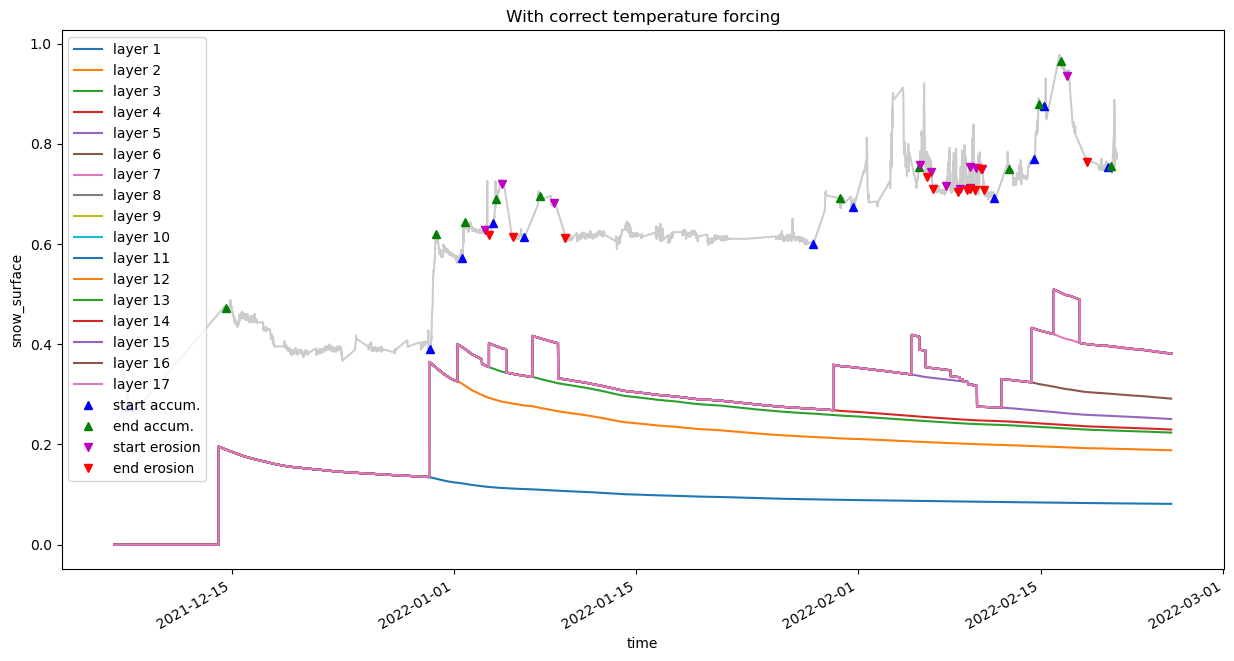

In [15]:
data_start_date = pd.to_datetime('2021-12-06T00:00')

plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution_temp, 17, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                     save_file=False, my_file_name='index_window_point_20-20_-1.png', my_title='With correct temperature forcing')

()

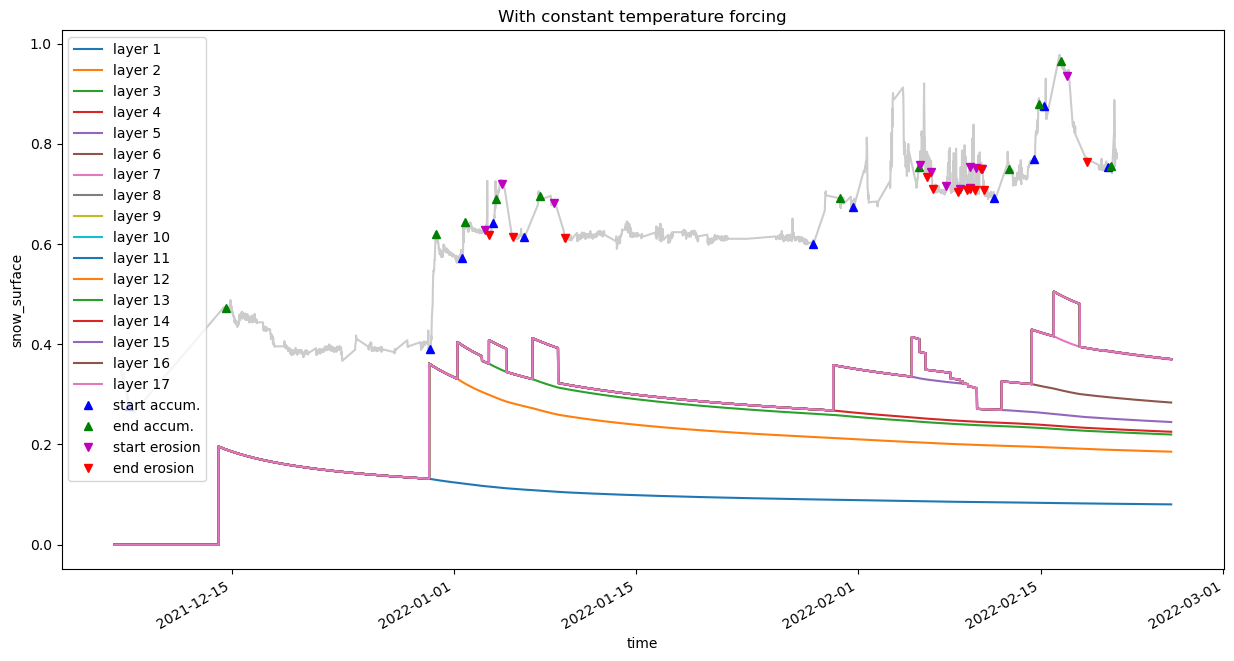

In [16]:
plot_simul_and_signal(data_set_used, x_sel, y_sel, depth_evolution, 17, data_start_date, dt, nb_iterations,
                          start_accumulation, end_accumulation, start_erosion, end_erosion,
                     save_file=False, my_file_name='index_window_point_20-20_-1.png', my_title='With constant temperature forcing')